In [1]:
%pylab inline

import pandas as pd
import numpy as np
import mne as mne
from glob import glob

Populating the interactive namespace from numpy and matplotlib


In [18]:
# get file names
n_subjects = 12
n_events = 6
event_names = ['HandStart', 'FirstDigitTouch', 'BothStartLoadPhase', 'LiftOff', 'Replace', 'BothReleased']
train_files = []
for subject in range(1, n_subjects + 1):
    train_files.append(glob('../input/train/subj%d_series*_data.csv' % (subject)))

In [19]:
def get_data(file_name):
    # get data from one file
    data_file = file_name
    events_file = data_file.replace('_data', '_events')

    data = pd.read_csv(data_file, index_col=0)
    events = pd.read_csv(events_file, index_col=0)

    # merge data and events
    data *= 1e-6
    merged = pd.merge(1e-6*data, events, left_index=True, right_index=True)

    # mne info structure
    ch_type = ['eeg']*len(data.columns) + ['stim']*len(events.columns)
    ch_names = merged.columns.tolist()
    montage = mne.channels.read_montage('standard_1005', ch_names)

    info = mne.create_info(ch_names, sfreq=500.0, ch_types=ch_type, montage=montage)
    info['filename'] = data_file

    # create raw object 
    raw = mne.io.RawArray(merged.values.T, info, verbose=False)
    picks = mne.pick_types(raw.info, eeg=True)
    
    return raw, picks

In [23]:
def plot_events(raw, picks, event, ax):
    # get event posision corresponding to replace
    raw_events = mne.find_events(raw, stim_channel=event, verbose=False)

    # epochs signal for 1.5 second before the movement
    epochs_before = mne.Epochs(raw, raw_events, {'during' : 1}, -1.5, -0.5, proj=False,
                    picks=picks, baseline=None, preload=True,
                    add_eeg_ref=False, verbose=False)

    # epochs signal for 1.5 second after the movement, this correspond to the rest period
    epochs_after = mne.Epochs(raw, raw_events, {'after' : 1}, 0.5, 1.5, proj=False,
                    picks=picks, baseline=None, preload=True,
                    add_eeg_ref=False, verbose=False)

    # workaround to be able to concatenate epochs
    epochs_after.times = epochs_before.times
    epochs = mne.epochs.concatenate_epochs([epochs_before, epochs_after])

    # get data 
    X = epochs.get_data()
    y = [1]*len(epochs_before) + [0]*len(epochs_after)

    # run CSP
    csp = mne.decoding.CSP(reg='lws')
    csp.fit(X,y)

    # prepare topoplot
    _, epos, _, _, _ = mne.viz.topomap._prepare_topo_plot(epochs, 'eeg', None)

    # plot first pattern
    pattern = csp.patterns_[0,:]
    pattern -= pattern.mean()

    ax.set_title(event)
    img, _ = mne.viz.topomap.plot_topomap(pattern, epos, axis=ax, show=False)

    #divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax_topo)
    # add axes for colorbar
    #ax_colorbar = divider.append_axes('right', size='5%', pad=0.05)
    #plt.colorbar(img, cax=ax_colorbar)

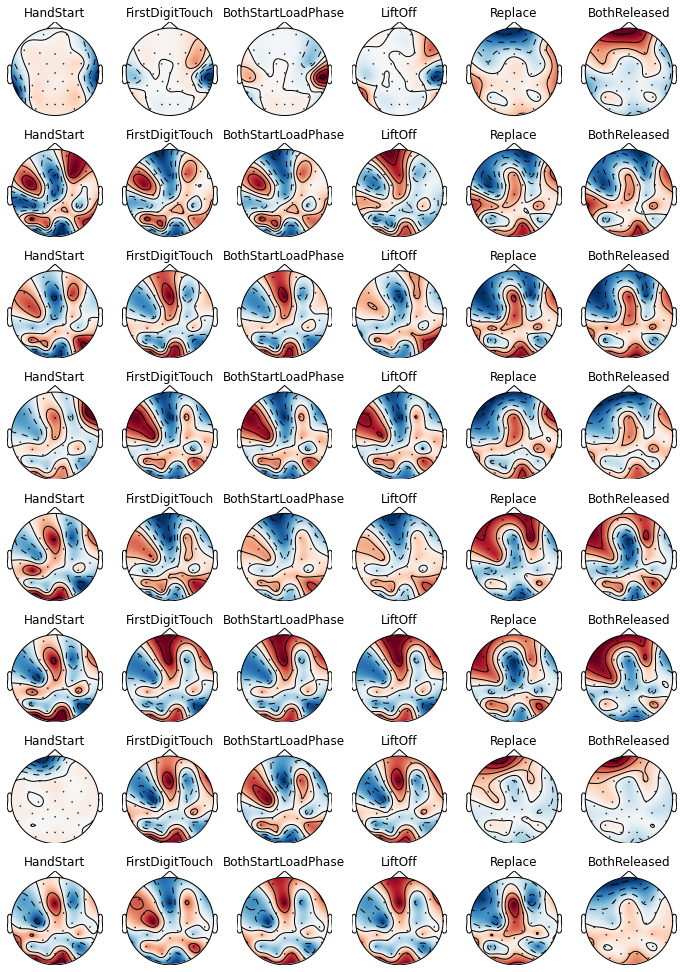

In [24]:
subject = 0
n_series = len(train_files[subject])
fig, ax = plt.subplots(n_series, n_events, figsize=(12, 2*n_series))
for series in range(n_series):
    raw, picks = get_data(train_files[subject][series])
    for event in range(n_events):
        plot_events(raw, picks, event_names[event], ax[series, event])